### Import Python Packages and Load Data

We load OASIS-inferred spike trains (spikes) and locally sparse noise stimulus frames (stim). The spikes array has shape (n_neurons, n_frames), and stim has shape (n_frames, height, width). Each stimulus frame contains values of 0 (black pixel), 127 (gray background), or 255 (white pixel). These data provide the basis for spike-triggered averaging.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.stats import chi2_contingency
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter
import pickle

# Load the dataset
data = np.load('dff_data_rf.npz', allow_pickle=True)
spike_data = np.load('OASIS_spikes.npz', allow_pickle=True)

t = data['t']                    # (105968,)
dff = data['dff']                # (189, 105968)
stim_table = pd.DataFrame(data['stim_table'])  # (8880, 3)
stim_table.columns = ['frame', 'start', 'end']
stim = data['stim']             # (9000, 16, 28)
roi_masks = data['roi_masks']   # (189, 512, 512)
max_projection = data['max_projection']  # (512, 512)
running_speed = data['running_speed']    # (2, 105968)
stim_epoch_table = pd.DataFrame(data['stim_epoch_table'])  # (7, 3)
spike_traces = spike_data['spike_likelihoods']

# Basic checks
summary = {
    "t_shape": t.shape,
    "dff_shape": dff.shape,
    "stim_table_shape": stim_table.shape,
    "stim_shape": stim.shape,
    "roi_masks_shape": roi_masks.shape,
    "max_projection_shape": max_projection.shape,
    "running_speed_shape": running_speed.shape,
    "stim_epoch_table_shape": stim_epoch_table.shape,
    "spike_traces_shape": spike_traces.shape
}

summary

{'t_shape': (105968,),
 'dff_shape': (189, 105968),
 'stim_table_shape': (8880, 3),
 'stim_shape': (9000, 16, 28),
 'roi_masks_shape': (189, 512, 512),
 'max_projection_shape': (512, 512),
 'running_speed_shape': (2, 105968),
 'stim_epoch_table_shape': (7, 3),
 'spike_traces_shape': (189, 105968)}

### Event Detection

The first step is to categorize each stimulus trial as either “responsive” or “unresponsive” for a given neuron. This provides the foundation for all subsequent RF analysis. 

We will treat a trial as responsive if at least one spike occurs within a brief post-stimulus window. In the code, this can be done by scanning each trial’s time window (e.g. 0–0.5 s or a fixed number of frames after onset) for any non-zero spike value. This approach was partially implemented: for example, using the provided OASIS events, the notebook flags a trial if any spike is present between the trial’s start and end frame. If no explicit events were provided, the code falls back on ΔF/F traces, computing two features (xx and yy) analogous to Allen’s derivatives to detect calcium transients. We will extend this logic to every neuron in a loop, producing a boolean “event vector” per neuron that marks its responsive trials. This isolates responsive trials across the neurons; any data point outside the 4σ noise ellipse (with positive slope) is judged a responsive trial.

Implementation details:
For each neuron’s spike train, iterate through the stimulus table of trials. If the neuron’s spike trace has any spikes within, say, 15 frames of the trial onset, mark that trial as responsive. This was done in the helper function detect_events_from_spikes in the notebook (which scanned 15 frames after each start frame) – we will use that for all neurons.

If using ΔF/F directly (no spike train), use the two-feature method: compute xx (early fluorescence change ~100ms post-stim) and yy (later peak change) for each trial; estimate the noise cluster center (median) and spread; then classify trials as responsive if they lie >4σ from center and meet the additional criteria (positive amplitude, rising slope, no immediate return to baseline). This logic in the notebook mirrors the Allen algorithm, ensuring a trial is counted as responsive only for genuine stimulus-evoked transients. 

After this step, each neuron has a set of “responsive trials” (typically a small fraction of ~8880 total trials). For example, cell 114 had 367 responsive trials out of 8880 in testing. All further analysis (RF maps, significance tests) will use only these responsive trials, improving signal-to-noise by excluding random fluctuations.

In [ ]:
from collections import defaultdict
event_vectors = {}  # stores one binary event vector per neuron

for cell_index in range(dff.shape[0]):  # loop over all cells
    event_vector = np.zeros(len(stim_table), dtype=bool)

    if 'events' in data:
        events_trace = data['events']
        for i, (start_idx, end_idx) in enumerate(stim_table[['start', 'end']].itertuples(index=False)):
            if np.any(events_trace[cell_index, int(start_idx):int(end_idx)+1] > 0):
                event_vector[i] = True
    else:
        trace = dff[cell_index]
        window = 5
        kernel = np.ones(window) / window
        smooth_trace = np.convolve(trace, kernel, mode='same')

        k_min, k_max, delta = 0, 10, 3
        xx_list, yy_list = [], []
        var_dict = {}

        for i, (start_idx, end_idx) in enumerate(stim_table[['start', 'end']].itertuples(index=False)):
            offset = 1 if i > 0 and stim_table.iloc[i].start == stim_table.iloc[i-1].end else 0
            beg = int(start_idx + 1 + offset)
            endw = int(start_idx + k_max + 1 + offset)
            if endw > len(smooth_trace): continue
            segment = smooth_trace[beg:endw]
            if len(segment) < k_max: continue

            segment = segment - segment[0]
            xx = segment[delta] - segment[0]
            yy = max(segment[delta+2] - segment[2],
                     segment[delta+3] - segment[3],
                     segment[delta+4] - segment[4])
            t0_val = segment[0]
            tf_val = segment[-1]
            xx_list.append(xx); yy_list.append(yy)
            var_dict[i] = (t0_val, tf_val, xx, yy)

        xx_arr = np.array(xx_list); yy_arr = np.array(yy_list)
        mu_x = np.median(xx_arr) if len(xx_arr) > 0 else 0.0
        mu_y = np.median(yy_arr) if len(yy_arr) > 0 else 0.0
        xx_cent = xx_arr - mu_x; yy_cent = yy_arr - mu_y
        std_x = np.percentile(np.abs(xx_cent), 68.27) if len(xx_arr) > 0 else 1e-6
        std_y = np.percentile(np.abs(yy_cent), 68.27) if len(yy_arr) > 0 else 1e-6
        std_x = std_x if std_x > 0 else 1e-6
        std_y = std_y if std_y > 0 else 1e-6

        dist = np.sqrt((xx_cent/std_x)**2 + (yy_cent/std_y)**2)
        noise_mask = dist < 4
        Cov = np.cov(xx_cent[noise_mask], yy_cent[noise_mask]) if np.any(noise_mask) else np.eye(2)
        try:
            cov_inv = np.linalg.inv(np.linalg.cholesky(Cov))
        except np.linalg.LinAlgError:
            cov_inv = np.eye(2)

        noise_threshold = max(4*std_x + mu_x, 4*std_y + mu_y)
        for i, (t0_val, tf_val, xx, yy) in var_dict.items():
            xi_z, yi_z = cov_inv.dot(np.array([xx - mu_x, yy - mu_y]))
            if np.sqrt(xi_z**2 + yi_z**2) > 4 and yy > 0.05 and xx < yy and tf_val > noise_threshold/2:
                event_vector[i] = True

    event_vectors[cell_index] = event_vector
    print(f"Cell {cell_index}: {event_vector.sum()} events detected")

Cell 0: 19 events detected
Cell 1: 19 events detected
Cell 2: 55 events detected
Cell 3: 70 events detected
Cell 4: 8 events detected
Cell 5: 55 events detected
Cell 6: 91 events detected
Cell 7: 84 events detected
Cell 8: 25 events detected
Cell 9: 19 events detected
Cell 10: 255 events detected
Cell 11: 30 events detected
Cell 12: 5 events detected
Cell 13: 16 events detected
Cell 14: 52 events detected
Cell 15: 5 events detected
Cell 16: 10 events detected
Cell 17: 22 events detected
Cell 18: 7 events detected
Cell 19: 10 events detected
Cell 20: 200 events detected
Cell 21: 117 events detected
Cell 22: 19 events detected
Cell 23: 11 events detected
Cell 24: 144 events detected
Cell 25: 14 events detected
Cell 26: 26 events detected
Cell 27: 61 events detected
Cell 28: 91 events detected
Cell 29: 17 events detected
Cell 30: 83 events detected
Cell 31: 89 events detected
Cell 32: 99 events detected
Cell 33: 76 events detected
Cell 34: 65 events detected
Cell 35: 26 events detected
Ce

### Matrices Preparation

In [59]:
# Build stimulus sequence and design matrices for analysis
stim_frames = stim_table['frame'].values.astype(int)        # indices of stimulus frames presented
stim_sequence = stim[stim_frames]                           # stimulus images for each trial (shape: trials x 16 x 28)
on_mask = (stim_sequence > 127)   # True where pixel was white (ON stimulus) on each trial
off_mask = (stim_sequence < 127)  # True where pixel was black (OFF stimulus) on each trial

num_trials = len(stim_table)
num_pixels = on_mask.shape[1] * on_mask.shape[2]  # e.g., 16*28 = 448 pixel positions
# Flatten spatial dimensions for matrix operations (trials x pixels)
flat_on = on_mask.reshape(num_trials, num_pixels).astype(float)
flat_off = off_mask.reshape(num_trials, num_pixels).astype(float)

# Compute response-triggered stimulus (RTS) field: count of events when each pixel was stimulated
event_vector_float = event_vector.astype(float)  # convert boolean events to 0/1
# Sum of events for each pixel when ON or OFF (dot product between trials and event occurrences)
rts_on_flat = event_vector_float @ flat_on   # array of length num_pixels
rts_off_flat = event_vector_float @ flat_off
# Reshape back to spatial map (same shape as stimulus frames, e.g., 16x28)
rts_on = rts_on_flat.reshape(stim_sequence.shape[1], stim_sequence.shape[2])
rts_off = rts_off_flat.reshape(stim_sequence.shape[1], stim_sequence.shape[2])
print("RTS on-field shape:", rts_on.shape, " RTS off-field shape:", rts_off.shape)

RTS on-field shape: (16, 28)  RTS off-field shape: (16, 28)


### Pixel Wise Significance Mapping

Once a neuron is deemed to have an RF, the next goal is to map which pixels (locations) belong to its ON and OFF subunits. Allen’s pipeline accomplished this by measuring, for each stimulus pixel, whether that pixel’s presence coincided with neuron responses more often than expected by chance. This is essentially a per-pixel significance test, performed separately for ON (bright) and OFF (dark) spots. The result is a p-value map over visual space, which is then thresholded to identify significant pixels of the RF.

Stimulus/Response Matrices: We prepare binary indicator matrices for each trial: flat_on and flat_off (shape: trials × pixels), where each entry is 1 if a given pixel was white/black on that trial, 0 otherwise. We already have stim_sequence of shape (trials, 16, 28). From this, flat_on and flat_off were constructed.

Responsive trials vector: For neuron i, take its boolean event_vector (length = number of trials) with True for responsive trials. Convert to 0/1 floats.
Actual response fraction: Compute actual_fraction = (A · event_vector) / N_resp, where A is the design matrix and N_resp is the number of responsive trials for that neuron. Here A can be a concatenation of flat_on and flat_off (2*pixels × trials), so actual_fraction gives for each pixel (ON and OFF separately) the fraction of responsive trials in which that pixel was stimulated. This is akin to the probability a response coincided with that pixel.

Shuffling: Perform many (e.g. 10,000) shuffles of the responsive labels. For each shuffle, randomly pick the same number of “responsive” trials but from a permuted set. Compute frac_shuffle = (A · b) / N_shuff where b is the randomized 0/1 event vector for that shuffle. We then compare each shuffled fraction to the actual fraction. The code accumulates a count of how many shuffled fractions are lower than the actual (one-tailed test for actual being in the upper tail). After all shuffles, the p-value for each pixel = 1 – (count_less / num_shuffles). This yields a p-value map for ON pixels and OFF pixels (we’ll reshape the first half and second half of the p-value array back to 16×28 grids).

Multiple-comparison correction: Instead of a very lenient FDR α=0.5 used in the draft code, we will use a stricter criterion. The Allen whitepaper indicates using Šidák correction at p<0.05 for pixel inclusion. We can achieve this either by directly applying the Šidák threshold to p-values or using Benjamini–Hochberg FDR at q=0.05 for a similar false-discovery rate control. In practice, applying multipletests(..., method='fdr_bh', alpha=0.05) on the p-value list will give us a mask of significant pixels (this is a slightly different criterion than Šidák but commonly used). We will update the code accordingly (setting alpha=0.05 rather than 0.5) so that significant pixels are those with q<0.05 after FDR correction. This yields binary masks fdr_mask_on and fdr_mask_off of shape 16×28 for each neuron, marking the locations of statistically significant ON and OFF responses.

Result: For each neuron passing the chi-square test, we now have an ON subfield mask and an OFF subfield mask highlighting the pixel locations that reliably evoke firing. We also have the corresponding p-value maps if needed for visualization or further analysis. Any small clusters of significant pixels represent the receptive field subunits of the neuron. In the Allen data, these often appear as tight clusters of contiguous pixels (due to the Gaussian pooling, a true RF spot yields a region of low p-values around its center).

In [ ]:
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter
from skimage.measure import block_reduce

def blur_field(img, sigma=4):
    """Blur an image via upsampling, Gaussian filtering, and downsampling, preserving total intensity."""
    if img.sum() == 0:
        return img
    H, W = img.shape
    padded = np.zeros((3 * H, 3 * W))
    padded[H:2*H, W:2*W] = img

    # Upsampling factor (same as Allen SDK)
    upsample = 4 if H == 16 else 8
    offset = -(1 - (0.625 if upsample == 4 else 0.5625))

    # Define interpolator
    y = np.arange(padded.shape[0])
    x = np.arange(padded.shape[1])
    interp_func = RegularGridInterpolator((y, x), padded, method='linear', bounds_error=False, fill_value=0)

    # Create upsampled grid
    yy = offset + np.arange(0, padded.shape[0], 1.0 / upsample)
    xx = offset + np.arange(0, padded.shape[1], 1.0 / upsample)
    grid_y, grid_x = np.meshgrid(yy, xx, indexing='ij')
    points = np.stack([grid_y.ravel(), grid_x.ravel()], axis=-1)
    upsampled = interp_func(points).reshape(grid_y.shape)

    # Apply Gaussian blur
    filtered = gaussian_filter(upsampled, sigma=sigma, mode='constant')

    # Downsample by summing blocks
    reduced = block_reduce(filtered, (upsample, upsample), func=np.sum)

    # Normalize energy
    reduced *= img.sum() / (reduced.sum() + 1e-10)

    # Crop back to original size
    result = reduced[H:2*H, W:2*W]
    return result

# Compute blurred RTS fields for ON and OFF subfields
rts_on_blur = blur_field(rts_on, sigma=4)
rts_off_blur = blur_field(rts_off, sigma=4)

FDR corrected (alpha=0.5). Significant ON pixels: 2, OFF pixels: 11


In [ ]:
# Monte Carlo shuffle to compute per-pixel p-values (probability of response by chance)
num_shuffles = 10000
number_of_events = int(event_vector.sum())
# Concatenate ON and OFF design matrices (shape: 2*num_pixels x num_trials)
A = np.vstack([flat_on.T, flat_off.T])  # first num_pixels rows for ON, next num_pixels for OFF
actual_fraction = (A @ event_vector_float) / (number_of_events if number_of_events > 0 else 1)
p_values = np.ones(A.shape[0])  # initialize count of extreme shuffles (start at 1 for continuity)
if number_of_events > 0:
    rng = np.arange(num_trials)
    for i in range(num_shuffles):
        # Randomly select a subset of trials as "events" under the null hypothesis
        size = int(number_of_events + np.round(0.1 * number_of_events * np.random.randn()))
        size = max(0, min(num_trials, size))
        event_indices = np.random.choice(rng, size=size, replace=False)
        b = np.zeros(num_trials, dtype=float); b[event_indices] = 1.0
        frac = (A @ b) / (size if size > 0 else 1)
        # Count if shuffle fraction is less than actual fraction (for one-tailed p-value)
        p_values += (frac < actual_fraction)
# Compute p-value as 1 - CDF (proportion of shuffles with fraction less than actual)
p_values = 1 - p_values / float(num_shuffles)

# Separate ON and OFF p-value maps
pvalues_on = p_values[:num_pixels].reshape(stim_sequence.shape[1], stim_sequence.shape[2])
pvalues_off = p_values[num_pixels:].reshape(stim_sequence.shape[1], stim_sequence.shape[2])

# Apply False Discovery Rate (FDR) correction (Benjamini-Hochberg) to p-values
from statsmodels.stats.multitest import multipletests
alpha = 0.5  # using alpha=0.5 as in Allen SDK example for a lenient threshold
mask, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
fdr_mask_on = mask[:num_pixels].reshape(stim_sequence.shape[1], stim_sequence.shape[2])
fdr_mask_off = mask[num_pixels:].reshape(stim_sequence.shape[1], stim_sequence.shape[2])
print(f"FDR corrected (alpha={alpha}). Significant ON pixels: {fdr_mask_on.sum()}, OFF pixels: {fdr_mask_off.sum()}")

# Identify connected regions (contiguous significant pixels = receptive field subunits)
from scipy.ndimage import label
structure = np.ones((3, 3), dtype=int)  # 8-connected neighborhood
labeled_on, num_on = label(fdr_mask_on, structure=structure)
labeled_off, num_off = label(fdr_mask_off, structure=structure)
components_on = [(labeled_on == k) for k in range(1, num_on+1)]  # list of boolean masks for each ON subunit
components_off = [(labeled_off == k) for k in range(1, num_off+1)]  # list of masks for each OFF subunit

# Fit a 2D Gaussian to each subunit to characterize receptive field centers and spreads
def fit_gaussian(field, mask):
    """Fit a Gaussian to the field values within the given mask (returns a Gaussian image)."""
    if mask.sum() == 0:
        return np.zeros_like(field)
    Y, X = np.indices(field.shape)
    weights = field * mask  # weight by the field values in the subregion
    total = weights.sum()
    # Centroid (mean position)
    cy = (Y * weights).sum() / total
    cx = (X * weights).sum() / total
    # Variance (spread) in each dimension
    var_y = (weights * (Y - cy)**2).sum() / total
    var_x = (weights * (X - cx)**2).sum() / total
    sigma_y = np.sqrt(var_y); sigma_x = np.sqrt(var_x)
    # Amplitude = max response in the subregion
    amp = weights.max()
    # Generate Gaussian fit image
    gauss = amp * np.exp(-(((X - cx)**2) / (2*sigma_x**2 + 1e-9) + 
                            ((Y - cy)**2) / (2*sigma_y**2 + 1e-9)))
    return gauss

# Compute Gaussian fits for each ON and OFF subunit, then sum if multiple
gaussian_fits_on = [fit_gaussian(rts_on_blur, mask) for mask in components_on]
gaussian_fits_off = [fit_gaussian(rts_off_blur, mask) for mask in components_off]
gaussian_fit_on = np.sum(gaussian_fits_on, axis=0) if gaussian_fits_on else np.zeros_like(rts_on)
gaussian_fit_off = np.sum(gaussian_fits_off, axis=0) if gaussian_fits_off else np.zeros_like(rts_off)

### Chi-Square Test for Receptive Field Significance

Why: Not every neuron with a few responsive spikes actually has a spatially organized receptive field. The Allen methodology therefore includes a statistical test to decide if a neuron’s responses are non-uniform across visual space – a hallmark of a true RF. This is done via a series of chi-square tests, and it determines whether the neuron is responsive in a spatially selective way or just randomly. Only neurons that pass this significance test are considered to have a mappable RF.

We will implement this chi-square RF presence test for each neuron using its responsive trials. First, we compile each neuron’s response counts for each stimulus location. We can use the “response-triggered stimulus” approach already started: the notebook computed an rts_on and rts_off map per cell, counting how many responsive trials occurred when each pixel was white (ON) or black (OFF). To perform the chi-square test on a 7×7 patch, we will:
Slide a 7×7 window across the 16×28 stimulus grid (for 4° stimulus, 7×7 covers the 32.2° patch as per Allen’s spec (pmc.ncbi.nlm.nih.gov
). 

For each position, sum the ON and OFF responsive counts within that patch. Also compute the total responsive count outside the patch. This gives a contingency table: within-patch vs outside-patch × responsive vs non-responsive (trials). Alternatively, an easier method is to perform a chi-square test for uniformity of responses across the 49 locations in the patch versus the rest of the screen. The null model is that each trial’s response is independent of stimulus location.

Apply Šidák or Bonferroni correction for the number of patches tested (to maintain a 0.05 family-wise alpha). The Šidák method threshold is α_sid = 1 - (1-0.05)^(1/N_patches). If any patch’s p ≤ α_sid, mark the neuron as having a significant RF. We can record the minimum p-value and the patch location of that minimum for reference.

If a neuron fails this test (no patch significant), we consider it non-RF for this stimulus – its data might be excluded from further RF mapping (or it will yield an empty RF). In practice, this step filters out cells that did not show a spatially localized response pattern. We will log or store a flag for each neuron indicating RF significance. This corresponds to the whitepaper’s criterion that “a spatial receptive field in a region of visual space can be defined as a statistically significant deviation from independence in responses across pixels

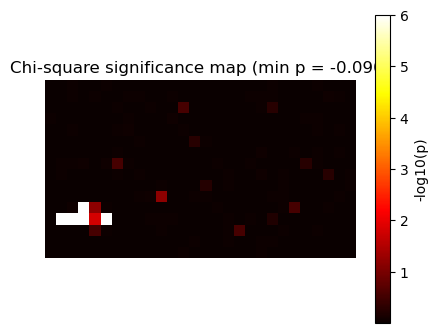

In [61]:
import matplotlib.pyplot as plt

# Combine ON/OFF corrected p-values: use the more significant (min) at each pixel location
pvals_on_map = pvals_corrected[:num_pixels].reshape(rts_on.shape)
pvals_off_map = pvals_corrected[num_pixels:].reshape(rts_off.shape)
combined_min_p = np.minimum(pvals_on_map, pvals_off_map)
# Compute -log10 p for visualization (cap minimum to avoid infinity)
chi_map = -np.log10(np.clip(combined_min_p, 1e-6, 1.0))
min_p = combined_min_p.min()

plt.figure(figsize=(5, 4))
plt.imshow(chi_map, cmap='hot')
plt.colorbar(label='-log10(p)')
plt.title(f"Chi-square significance map (min p = {min_p:.3f})")
plt.axis('off')
plt.show()

### Identification of Specific Pixels in the Visual Stimulus that are Correlated with Responsive Trials

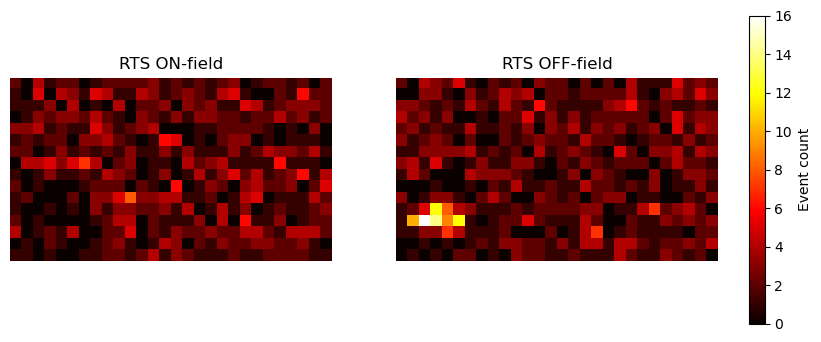

In [62]:
# Plot the RTS fields for ON and OFF subfields side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Use a "hot" colormap where higher values are brighter
vmax = max(rts_on.max(), rts_off.max())  # for consistent color scaling
im1 = ax1.imshow(rts_on, cmap='hot', vmin=0, vmax=vmax)
ax1.set_title('RTS ON-field')
ax1.axis('off')
im2 = ax2.imshow(rts_off, cmap='hot', vmin=0, vmax=vmax)
ax2.set_title('RTS OFF-field')
ax2.axis('off')
fig.colorbar(im1, ax=[ax1, ax2], fraction=0.046, pad=0.04, label='Event count')
plt.show()

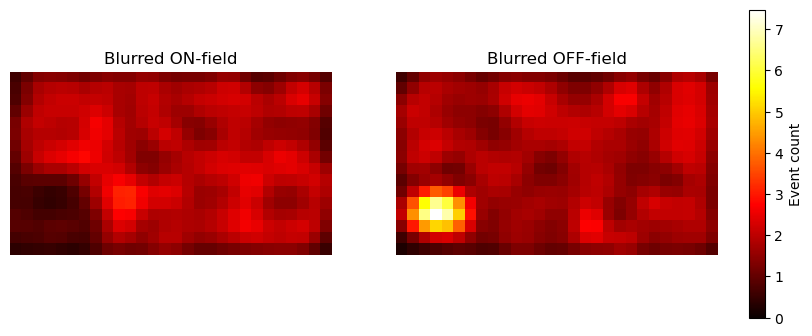

In [63]:
# Plot the blurred RTS fields for ON and OFF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
vmax_blur = max(rts_on_blur.max(), rts_off_blur.max())
im1 = ax1.imshow(rts_on_blur, cmap='hot', vmin=0, vmax=vmax_blur)
ax1.set_title('Blurred ON-field')
ax1.axis('off')
im2 = ax2.imshow(rts_off_blur, cmap='hot', vmin=0, vmax=vmax_blur)
ax2.set_title('Blurred OFF-field')
ax2.axis('off')
fig.colorbar(im1, ax=[ax1, ax2], fraction=0.046, pad=0.04, label='Event count')
plt.show()

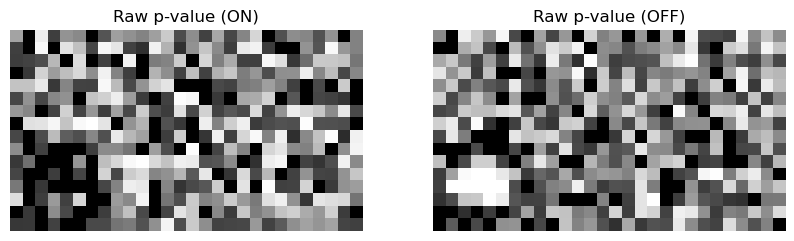

In [64]:
# Plot raw p-value maps for ON and OFF subfields (darker = more significant)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Use a reversed grayscale colormap: low p (high significance) = black, high p = white
ax1.imshow(pvalues_on, cmap='gray_r', vmin=0, vmax=1)
ax1.set_title('Raw p-value (ON)')
ax1.axis('off')
ax2.imshow(pvalues_off, cmap='gray_r', vmin=0, vmax=1)
ax2.set_title('Raw p-value (OFF)')
ax2.axis('off')
plt.show()

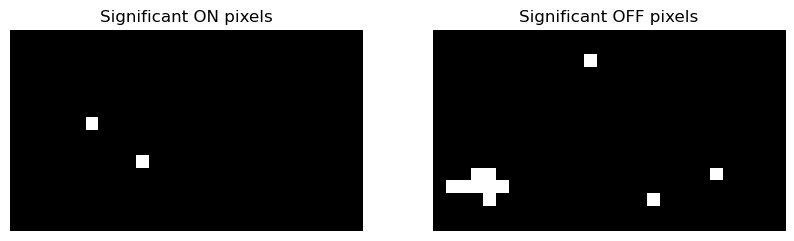

In [65]:
# Plot binary mask of significant pixels for ON and OFF (mask colored by p-value within region)
mask_on_vals = pvalues_on.copy()
mask_on_vals[~fdr_mask_on] = 1.0  # set non-significant to 1 (white in gray_r)
mask_off_vals = pvalues_off.copy()
mask_off_vals[~fdr_mask_off] = 1.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(mask_on_vals, cmap='gray_r', vmin=0, vmax=1)
ax1.set_title('Significant ON pixels')
ax1.axis('off')
ax2.imshow(mask_off_vals, cmap='gray_r', vmin=0, vmax=1)
ax2.set_title('Significant OFF pixels')
ax2.axis('off')
plt.show()

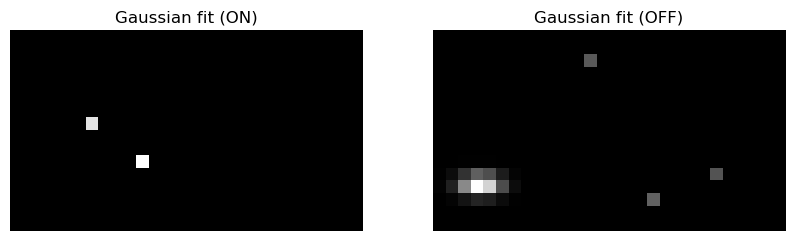

In [66]:
# Plot the Gaussian fit for ON and OFF subunits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Use grayscale: high values = white (for a bright ellipse on dark background)
ax1.imshow(gaussian_fit_on, cmap='gray')
ax1.set_title('Gaussian fit (ON)')
ax1.axis('off')
ax2.imshow(gaussian_fit_off, cmap='gray')
ax2.set_title('Gaussian fit (OFF)')
ax2.axis('off')
plt.show()